# Data preparation

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

Image preprocessing: *variant 3*

1. Alignement between panchromatic and SWIR

2. Upsample SWIR

3. Pansharpen MS

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import cv2 

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [8]:
import sys
sys.path.append("../common/")

from data_utils import TRAIN_IMAGE_IDS, get_resized_polygons, generate_label_file, LABELS
from image_utils import generate_pansharpened, generated_upsampled_swir, imwrite, get_image_data, get_filename, generate_aligned_swir
from visu_utils import display_img_1b

In [9]:
import os
from image_utils import TRAIN_LABEL_TILES, TRAIN_DATA, get_tile_filename

Generate images : 17 bands images

In [10]:
do_generate_17b_images = True
do_generate_labels = True

for i, image_id in enumerate(TRAIN_IMAGE_IDS):
    print "--", image_id, i+1, "/", len(TRAIN_IMAGE_IDS)
    
    if do_generate_17b_images:
        # Generate aligned swir file
        generate_aligned_swir(image_id)    

        # Generate pansharpened
        generate_pansharpened(image_id, 'ms')
        generated_upsampled_swir(image_id, 'swir_aligned')

    if do_generate_labels:
        # Generate label image
        generate_label_file(image_id, multi_dim=True)        
        
    if do_generate_17b_images:
        img_pan = get_image_data(image_id, 'pan')
        img_ms = get_image_data(image_id, 'ms_pan')
        img_swir = get_image_data(image_id, 'swir_aligned_upsampled')
        h, w = img_pan.shape
        x = np.zeros((h, w, 17), dtype=np.uint16)
        x[:,:,0] = img_pan; x[:,:,1:9] = img_ms; x[:,:,9:] = img_swir
        imwrite(get_filename(image_id, '17b'), x)

-- 6040_2_2 1 / 25
-- 6120_2_2 2 / 25
-- 6120_2_0 3 / 25
-- 6090_2_0 4 / 25
-- 6040_1_3 5 / 25
-- 6040_1_0 6 / 25
-- 6100_1_3 7 / 25
-- 6010_4_2 8 / 25
-- 6110_4_0 9 / 25
-- 6140_3_1 10 / 25
-- 6110_1_2 11 / 25
-- 6100_2_3 12 / 25
-- 6150_2_3 13 / 25
-- 6160_2_1 14 / 25
-- 6140_1_2 15 / 25
-- 6110_3_1 16 / 25
-- 6010_4_4 17 / 25
-- 6170_2_4 18 / 25
-- 6170_4_1 19 / 25
-- 6170_0_4 20 / 25
-- 6060_2_3 21 / 25
-- 6070_2_3 22 / 25
-- 6010_1_2 23 / 25
-- 6040_4_4 24 / 25
-- 6100_2_2 25 / 25


Create mean / std tile for a dataset

In [16]:
import os
from glob import glob
all_train_files = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_files = np.array([s[len(TRAIN_DATA)+1:] for s in all_train_files])

In [39]:
trainset_ids = all_train_files

ll = len(trainset_ids)
image_id = trainset_ids[0][:-4]
img_17b = get_image_data(image_id, '17b').astype(np.float)
# Init mean/std images
mean_image = np.zeros((3349, 3404, 17))
std_image = np.zeros_like(mean_image)

h, w, _ = img_17b.shape
mean_image[:h,:w,:] += img_17b
std_image += np.power(mean_image, 2)

for i, image_id in enumerate(trainset_ids[1:]):
    print "--", i+1, image_id
    img_17b = get_image_data(image_id[:-4], '17b').astype(np.float)
    h, w, _ = img_17b.shape
    mean_image[:h,:w,:] += img_17b
    std_image[:h,:w,:] += np.power(img_17b, 2)
        
mean_image *= 1.0/ll
std_image *= 1.0/ll
std_image -= np.power(mean_image, 2)
std_image = np.sqrt(std_image)

-- 1 6010_4_2.tif
-- 2 6010_4_4.tif
-- 3 6040_1_0.tif
-- 4 6040_1_3.tif
-- 5 6040_2_2.tif
-- 6 6040_4_4.tif
-- 7 6060_2_3.tif
-- 8 6070_2_3.tif
-- 9 6090_2_0.tif
-- 10 6100_1_3.tif
-- 11 6100_2_2.tif
-- 12 6100_2_3.tif
-- 13 6110_1_2.tif
-- 14 6110_3_1.tif
-- 15 6110_4_0.tif
-- 16 6120_2_0.tif
-- 17 6120_2_2.tif
-- 18 6140_1_2.tif
-- 19 6140_3_1.tif
-- 20 6150_2_3.tif
-- 21 6160_2_1.tif
-- 22 6170_0_4.tif
-- 23 6170_2_4.tif
-- 24 6170_4_1.tif


In [40]:
print mean_image.dtype, mean_image.min(), mean_image.max(), mean_image.shape
print std_image.dtype, std_image.min(), std_image.max(), std_image.shape

float64 0.0 5261.28 (3349, 3404, 17)
float64 0.0 3649.91095037 (3349, 3404, 17)


In [43]:
mean_fname = os.path.join(TRAIN_DATA, 'mean_image.npz')
std_fname = os.path.join(TRAIN_DATA, 'std_image.npz')
if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
    np.savez(mean_fname, mean_image)
    np.savez(std_fname, std_image)

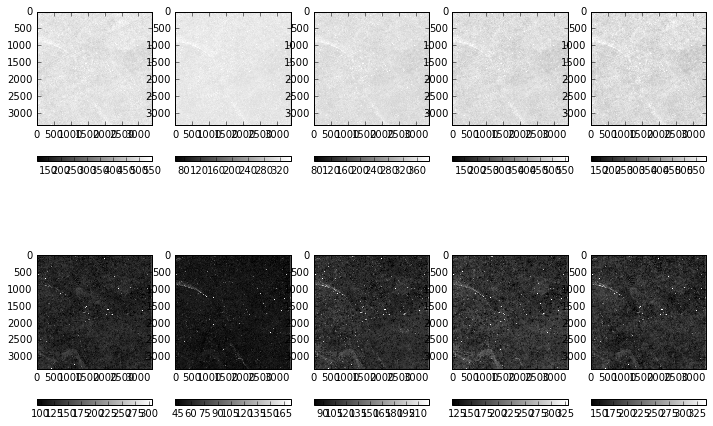

In [42]:
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    display_img_1b(mean_image[:,:,i])

for i in range(5):
    plt.subplot(2,5,5+i+1)
    display_img_1b(std_image[:,:,i])

In [117]:
def inversion(tile):
    inv_tile = tile + tile.min() + 100
    eps = 1e-7
    inv_tile = np.power(inv_tile+eps, -1.0)
    mean = np.mean(inv_tile)
    std = np.std(inv_tile)
    inv_tile = (inv_tile - mean)/std
    return inv_tile

In [84]:
count = 0

-- 0 6010_4_4_3072_1728.tif -0.232726256788 0.176870446737 (256L, 256L, 17L)
-- 1 6010_4_4_3072_2176.tif -0.246076510752 0.143217154541 (256L, 256L, 17L)
-- 2 6010_4_4_3072_2624.tif -0.241625480505 0.290977790965 (256L, 256L, 17L)
-- 3 6010_4_4_3072_3072.tif -0.20921606634 0.253230111867 (256L, 256L, 17L)
-- 4 6010_4_4_3072_384.tif -0.238901890141 0.204530204508 (256L, 256L, 17L)


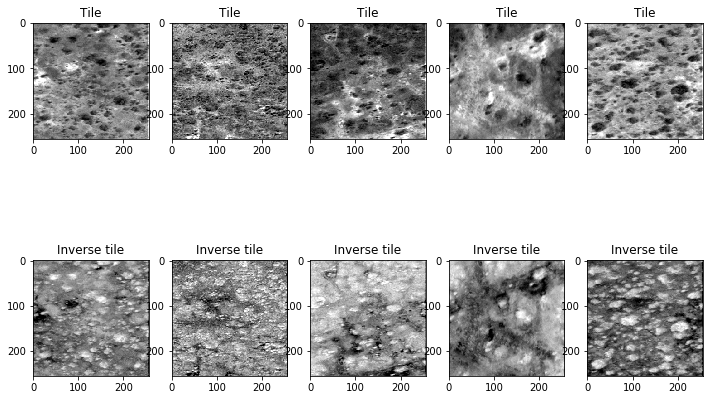

In [125]:
plt.figure(figsize=(12,8))
for i, tile_id in enumerate(trainset_ids[count:count+5]):
    
    tile = get_image_tile_data(os.path.join(TRAIN_DATA,tile_id)).astype(np.float)
    tile -= mean_tile_image
    tile /= std_tile_image
    
    inv_tile = inversion(tile)   
    
    print "--", i, tile_id, tile.min(), tile.max(), tile.shape
    plt.subplot(2,5,i + 1)
    display_img_1b(tile[:,:,i])
    plt.title("Tile")
    
    plt.subplot(2,5,5 + i + 1)
    display_img_1b(inv_tile[:,:,i])
    plt.title("Inverse tile")

    
count += 5

In [41]:
615  **2

378225

In [38]:
# from data_utils import generate_label_image2
# img_label = generate_label_image2('6120_2_0')
# print img_label.shape, img_label.dtype,  img_label.min(), img_label.max()

In [12]:
gimg_label = GeoImage(get_filename('6010_1_2', 'label'))
img_label = gimg_label.get_data()
print img_label.shape, img_label.dtype, img_label.min(), img_label.max()

(3348L, 3396L, 11L) uint8 0 1


In [13]:
gimg_label = GeoImage(get_filename('6110_3_1', 'label'))
img_label = gimg_label.get_data()
print img_label.shape, img_label.dtype, img_label.min(), img_label.max()

(3348L, 3396L, 11L) uint8 0 1


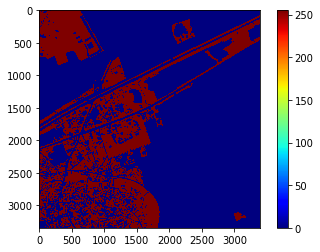

In [142]:
plt.figure()
display_img_1b(img_label[:,:,0], cmap=plt.get_cmap('jet'))
plt.colorbar()

In [143]:
gimg_test = GeoImage(TRAIN_DATA + '/6120_2_0_1280_1728.tif')
img = gimg_test.get_data()
print img.shape, img.dtype, img.min(), img.max()

gimg_test_label = GeoImage(TRAIN_LABEL_TILES + '/6120_2_0_1280_1728.tif')
img_label = gimg_test_label.get_data()
print img_label.shape, img_label.dtype, img_label.min(), img_label.max()


(256L, 256L, 17L) uint16 311 1148
(256L, 256L, 11L) uint8 0 199


ERROR! Session/line number was not unique in database. History logging moved to new session 476


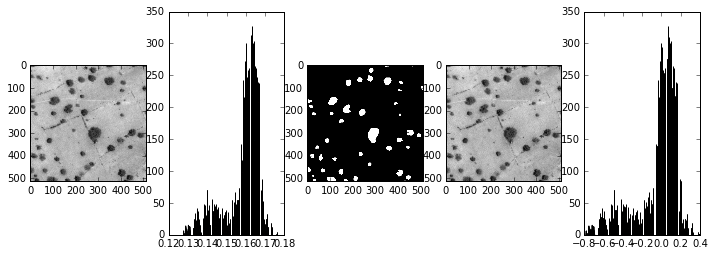

In [17]:
nimg = img * 1.0/2**12
nnimg = (img - np.mean(img))/np.std(img)
plt.figure(figsize=(12,4))
plt.subplot(151)
plt.imshow(nimg[:,:,0], cmap='gray')
plt.subplot(152)
plt.hist(nimg[:,:,0])
plt.subplot(153)
plt.imshow(img_label[:,:,5], cmap='gray')
plt.subplot(154)
plt.imshow(nnimg[:,:,0], cmap='gray')
plt.subplot(155)
_ = plt.hist(nnimg[:,:,0])

In [132]:
gimg_test = GeoImage(TRAIN_DATA + '/6110_3_1_1280_1728.tif')
gimg_test = GeoImage(TRAIN_DATA + '/6110_3_1_1280_1728.tif')

img = gimg_test.get_data()
print img.shape, img.dtype, img.min(), img.max()

gimg_test_label = GeoImage(TRAIN_LABEL_TILES + '/6110_3_1_1280_1728.tif')
img_label = gimg_test_label.get_data()
print img_label.shape, img_label.dtype, img_label.min(), img_label.max() 


(256L, 256L, 17L) uint16 197 2304
(256L, 256L, 11L) uint8 0 255


In [136]:
for i in range(img_label.shape[2]):
    print i, img_label[:,:,i].min(), img_label[:,:,i].max()

0 0 1
1 0 1
2 0 1
3 0 0
4 0 0
5 0 1
6 0 1
7 0 0
8 0 255
9 0 253
10 0 254


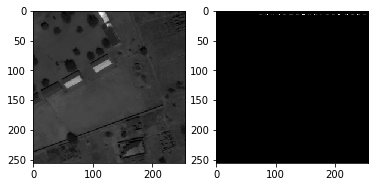

In [138]:
nimg = img * 1.0/2**12
plt.figure()
plt.subplot(121)
plt.imshow(nimg[:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(img_label[:,:,10], cmap='gray')

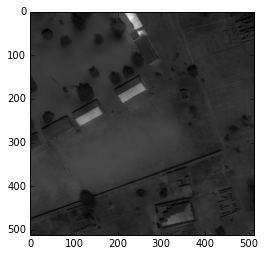

In [46]:
from image_utils import get_image_tile_data

img = get_image_tile_data(TRAIN_DATA + '/6110_3_1_1280_1728.tif')

nimg = img * 1.0/2**12
plt.figure()
plt.imshow(nimg[:,:,16], cmap='gray')

In [47]:
from image_utils import get_image_data
label_img = get_image_data("6100_2_2", 'label')
label_img.shape

(3348, 3391, 11)

In [9]:

def normalize_image(img_data, interp=cv2.INTER_CUBIC):
    img_data = cv2.resize(img_data, dsize=(512, 512), interpolation=interp)
    out = np.zeros_like(img_data)
    for c in range(img_data.shape[2]):        
        min_value, max_value, _, _ = cv2.minMaxLoc(img_data[:,:,c])
        out[:,:,c] = (img_data[:,:,c] - min_value)/(max_value - min_value + 0.0001)            
    out = out.transpose([2,0,1])
    out = out[None,:]
    return out

In [19]:
gimg_test = GeoImage(TRAIN_DATA + '/6120_2_0_1280_1728.tif')
img = gimg_test.get_data()
print img.shape, img.dtype, img.min(), img.max()

(512, 512, 17) uint16 308 1153


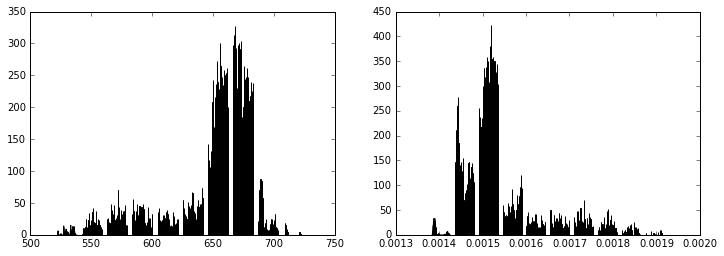

In [20]:
inv_img = 1.0/img

plt.figure(figsize=(12,4))
plt.subplot(121)
_ = plt.hist(img[:,:,0])
plt.subplot(122)
_ = plt.hist(inv_img[:,:,0])

Generate 1-band labels and 17 bands image tiles

In [18]:
# tile_size = (512, 512)
# overlapping = 64
# include_nodata = True

# for i, image_id in enumerate(TRAIN_IMAGE_IDS):
#     print "--", image_id, i, "/", len(TRAIN_IMAGE_IDS)
    
#     # Generate aligned swir file
#     generate_aligned_swir(image_id)    
    
#     # Generate pansharpened
#     generate_pansharpened(image_id, 'ms')
#     generate_pansharpened(image_id, 'swir_aligned')
#     # Generate label image
#     generate_label_file(image_id, multi_dim=False)

#     gimg_pan = GeoImage(get_filename(image_id, 'pan'))
#     gimg_ms = GeoImage(get_filename(image_id, 'ms_pan'))
#     gimg_swir = GeoImage(get_filename(image_id, 'swir_pan'))
#     gimg_label = GeoImage(get_filename(image_id, 'label_1d'))
    
#     gimg_pan_tiles = GeoImageTiler(gimg_pan, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
#     gimg_ms_tiles = GeoImageTiler(gimg_ms, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
#     gimg_swir_tiles = GeoImageTiler(gimg_swir, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
#     gimg_label_tiles = GeoImageTiler(gimg_label, tile_size=tile_size, overlapping=overlapping, include_nodata=include_nodata, nodata_value=0.0)
    
#     for tile_info_pan, tile_info_ms, tile_info_swir, tile_info_label in \
#             zip(gimg_pan_tiles, gimg_ms_tiles, gimg_swir_tiles, gimg_label_tiles):
    
#         tile_pan, xoffset_pan, yoffset_pan = tile_info_pan
#         tile_ms, xoffset_ms, yoffset_ms = tile_info_ms
#         tile_swir, xoffset_swir, yoffset_swir = tile_info_swir
#         tile_label, xoffset_label, yoffset_label = tile_info_label

#         h, w, _ = tile_pan.shape
#         x = np.zeros((h, w, 17), dtype=np.uint16)
#         x[:,:,0] = tile_pan[:,:,0]; x[:,:,1:9] = tile_ms; x[:,:,9:] = tile_swir
#         imwrite(get_tile_filename(image_id, xoffset_ms, yoffset_ms, '17b'), x)
#         y = tile_label
#         imwrite(get_tile_filename(image_id, xoffset_label, yoffset_label, 'label_1d'), y)    